# Parameter Estimation Workflow for CR Model

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import LSTM
from scipy.stats import norm, gaussian_kde
from scipy.integrate import solve_ivp, dblquad
import random

from bayesflow.networks import InvertibleNetwork
from bayesflow.amortizers import SingleModelAmortizer
from bayesflow.trainers import ParameterEstimationTrainer
from bayesflow.models import GenerativeModel

In [2]:
%load_ext autoreload
%autoreload 2

## Simulator settings

In [3]:
def prior(batch_size):
    """
    Samples from the prior 'batch_size' times.
    ----------
    Output:
    theta : np.ndarray of shape (batch_size, theta_dim) 
    """    
    # Prior range for log-parameters: k_1, k_2 ~ N(-0.75, 0.25²) iid.
    p_samples = np.random.normal(-0.75, 0.25, size=(batch_size, 2))
    return p_samples.astype(np.float32)


# ODE model for conversion reaction    
def conversion_reaction(t, x, theta):
    theta = 10**theta
    return np.array([-theta[0]*x[0]+theta[1]*x[1], theta[0]*x[0]-theta[1]*x[1]])

x0 = [1,0]   # initial condition       
sigma = 0.015   # noise standard deviation
n_obs = 3
time_points = np.linspace(0, 10, n_obs)
missing_max = 2

We build an amortized parameter estimation network.

In [4]:
bf_meta = {
    'n_coupling_layers': 5,
    's_args': {
        'units': [64, 64, 64],
        'activation': 'elu',
        'initializer': 'glorot_uniform',
    },
    't_args': {
        'units': [64, 64, 64],
        'activation': 'elu',
        'initializer': 'glorot_uniform',
    },
    'n_params': 2
}

## Computational faithfulness

In [5]:
true_params = np.load("true_params.npy")
mcmc_means = np.load("mcmc_means.npy")
mcmc_samples = np.load("mcmc_samples.npy")
x_augment01 = np.load("x_augment01.npy")

In [11]:
mcmc_means[mcmc_means[:,1]>-0.4]

array([[-0.32464844, -0.3926193 ],
       [-0.77656308, -0.30797705],
       [-0.89760375, -0.36986496]])

In [12]:
x_augment01[mcmc_means[:,1]>-0.4]

array([[[-0.00321237,  1.        ],
        [ 0.56679356,  1.        ],
        [ 0.5022447 ,  1.        ]],

       [[-1.        ,  0.        ],
        [ 0.26160282,  1.        ],
        [ 0.23183891,  1.        ]],

       [[-0.02211037,  1.        ],
        [ 0.21920094,  1.        ],
        [ 0.21454851,  1.        ]]], dtype=float32)

In [13]:
# Data set 1 (n_missing = 1)
param_prior_1 = np.array([[-0.9764454, -0.6597913]])
result_1 = [np.array([-0.01174284,  0.27580237,  0.3169578 ]), np.array([0, 1]), np.array([0., 5.])]

# Data set 2 (n_missing = 2)
param_prior_2 = np.array([[-0.71007127, -0.53789186]])
result_2 = [np.array([-0.00321237, 0.56679356, 0.5022447]), np.array([0,1,2]), np.array([0., 5., 10.])]

param_priors = [param_prior_1, param_prior_2]
results = [result_1, result_2]

In [14]:
# Insert -1
summary_net = LSTM(8)
inference_net = InvertibleNetwork(bf_meta)
amortizer_insert = SingleModelAmortizer(inference_net, summary_net)
ParameterEstimationTrainer(network=amortizer_insert, checkpoint_path='./CR3_insert-1_5ACB_[64,64,64]_LSTM(8)_ckpts', skip_checks=True)

# Augment by 0/1
summary_net = LSTM(8)
inference_net = InvertibleNetwork(bf_meta)
amortizer_augment01 = SingleModelAmortizer(inference_net, summary_net)
ParameterEstimationTrainer(network=amortizer_augment01, checkpoint_path='./CR3_augment01_5ACB_[64,64,64]_LSTM(8)_ckpts', skip_checks=True)

# Time labels
summary_net = LSTM(8)
inference_net = InvertibleNetwork(bf_meta)
amortizer_timelabels = SingleModelAmortizer(inference_net, summary_net)
ParameterEstimationTrainer(network=amortizer_timelabels, checkpoint_path='./CR3_timepoints_5ACB_[64,64,64]_LSTM(8)_ckpts', skip_checks=True)

amortizers = {"insert": amortizer_insert, "augment01": amortizer_augment01, "timelabels": amortizer_timelabels}

TRAINER INITIALIZATION: No generative model provided. Only offline learning mode is available!
Networks loaded from ./CR3_insert-1_5ACB_[64,64,64]_LSTM(8)_ckpts\ckpt-300
TRAINER INITIALIZATION: No generative model provided. Only offline learning mode is available!
Networks loaded from ./CR3_augment01_5ACB_[64,64,64]_LSTM(8)_ckpts\ckpt-300
TRAINER INITIALIZATION: No generative model provided. Only offline learning mode is available!
Networks loaded from ./CR3_timepoints_5ACB_[64,64,64]_LSTM(8)_ckpts\ckpt-300


In [15]:
# Encode missing data
x_datas = []
for result in results:
    x_datas.append({})
    
    x_data = np.ones((1, n_obs, 1), dtype=np.float32)
    x_data[0, :, 0] = result[0]
    missing_indices = np.setdiff1d(range(n_obs), result[1])
    x_data[0][missing_indices] = np.array([-1.0])
    x_datas[-1]["insert"] = x_data
    
    x_data = np.ones((1, n_obs, 2), dtype=np.float32)
    x_data[0, :, 0] = result[0]
    missing_indices = np.setdiff1d(range(n_obs), result[1])
    x_data[0][missing_indices] = np.array([-1.0, 0.0])
    x_datas[-1]["augment01"] = x_data
    
    n_present = len(result[1])
    x_data = np.ones((1, n_present, 2), dtype=np.float32)
    x_data[0, :, 0] = result[0][result[1]]
    x_data[0, :, 1] = result[2]
    x_datas[-1]["timelabels"] = x_data

In [16]:
# Sample from BayesFlow
n_post_samples = 7500
samples = []
for result_ix, result in enumerate(results):
    samples.append({})
    for amortizer_id, amortizer in amortizers.items():
        x_data = x_datas[result_ix][amortizer_id]
        samples[-1][amortizer_id] = amortizer.sample(x_data, n_post_samples)

## Posterior plots

In [17]:
# Calculate analytical posteriors
def get_posterior(result):
    
    def prior_eval(x,y):   
        # Evaluates prior probability p(theta) according to k_1, k_2 ~ N(-0.75, 0.25²) iid.
        return norm.pdf(x,-0.75,0.25) * norm.pdf(y,-0.75,0.25)

    def likelihood(x,y):   
        # Calculates likelihood of available data
        x = 10**x
        y = 10**y
        s = x + y
        b = x/s
        state_2 = lambda t: b - b * np.exp(-s*t)
        sol = state_2(result[2])
        residual = (result[0][result[1]] - sol)/sigma
        nllh = np.sum(np.log(2*np.pi*sigma**2)+residual**2)/2
        return np.exp(-nllh)

    def unnormalized_posterior(x,y):   
        # Evaluates the unnormalized posterior probability according to Bayes' formula
        return likelihood(x,y) * prior_eval(x,y)
    
    # scaling factor
    scaling_factor = dblquad(unnormalized_posterior, -2.25, 0.75, lambda y: -2.25, lambda y: 0.75)

    posterior = lambda x,y: unnormalized_posterior(x,y) / scaling_factor[0]
    return posterior

posteriors = []
for result_ix, result in enumerate(results):
    posteriors.append({})
    for amortizer_id, param_samples in samples[result_ix].items():
        posteriors[-1][amortizer_id] = get_posterior(result)

In [18]:
cmap = "viridis"
amortizer_labels = {"insert": "Insert $-1$", "augment01": "Augment by $0/1$", "timelabels": "Time labels"}

def plot_posterior(ax, result, posterior, param_samples, amortizer_id, result_ix, levels=None):
    mins, maxs = param_samples.min(axis=0), param_samples.max(axis=0)
    xmin, ymin = mins
    xmax, ymax = maxs
    
    # Level sets of analytic posterior distribution
    grid = 201
    A = np.linspace(xmin, xmax, grid)
    B = np.linspace(ymin, ymax, grid)
    true_posterior = np.zeros((grid, grid))
    for iy in range(0, grid):
        for ix in range(0, grid):
            true_posterior[iy][ix] = posterior(A[ix], B[iy]) 
    if levels is not None:
        _cs = ax.contour(A, B, true_posterior, levels, cmap=cmap)
    else:
        _cs = ax.contour(A, B, true_posterior, cmap=cmap)
    
    # Kernel density estimator of BayesFlow samples
    a = param_samples[:, 0]
    b = param_samples[:, 1]
    ab = np.vstack([a, b])
    z = gaussian_kde(ab)(ab)
    ida = z.argsort()  # Sort the points by density, so that the densest points are plotted last
    a, b, z = a[ida], b[ida], z[ida]
    approximate_posterior = ax.scatter(a, b, c=z, s=10, cmap=cmap, alpha=0.1)

    ax.set_xlabel('Parameter $k_1$')
    ax.set_ylabel('Parameter $k_2$')
    ax.set_title(amortizer_labels[amortizer_id])

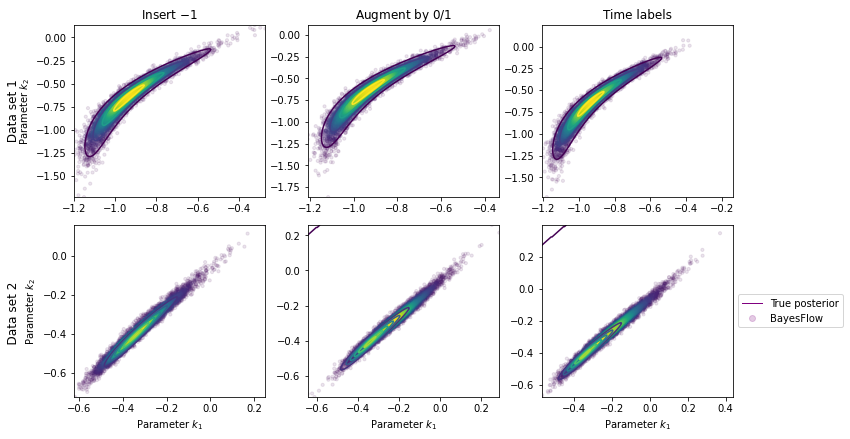

In [20]:
fig, axes = plt.subplots(2, 3, figsize=(12, 6.2))

for result_ix, result in enumerate(results):
    for amortizer_ix, (amortizer_id, amortizer) in enumerate(amortizers.items()):
        posterior = posteriors[result_ix][amortizer_id]
        param_samples = samples[result_ix][amortizer_id]
        
        ax = axes[result_ix, amortizer_ix]
        if result_ix == 0:
            levels = np.array([1, 4.25, 11, 19])
        else:
            levels = None
        plot_posterior(ax, result, posterior, param_samples, amortizer_id, result_ix, levels=levels)
        #ax.set_yticks([-1.5, -1.0, -0.5, 0.0])
        if amortizer_ix > 0:
            ax.set_ylabel(None)
        if result_ix == 0:
            ax.set_xlabel(None)
        else:
            ax.set_title(None)
            
# Legend
legend_elements = [
    Line2D([0], [0], color="purple", lw=1, label="True posterior"),
    Line2D([0], [0], color="purple", markerfacecolor="purple", marker="o", lw=0, markersize=6, alpha=0.2, label="BayesFlow"),
]
axes[-1,-1].legend(handles=legend_elements, loc="center left", bbox_to_anchor=(1, 0.5))
fig.supylabel('    Data set 2                                    Data set 1')

fig.tight_layout()
for fmt in ["png", "pdf"]:
    fig.savefig(f"figures/control.{fmt}", dpi=300, bbox_inches='tight')